<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [42]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [43]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [44]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [45]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** $y_{si}, ; i=1,2,3,4$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



In [46]:
# graficos incrustados
sns.set_style("whitegrid")
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

y_s1.head()


,pdq
date,
2015-01-04,23.337079
2015-01-11,25.687861
2015-01-18,26.547170
2015-01-25,27.267016
2015-02-01,28.213018


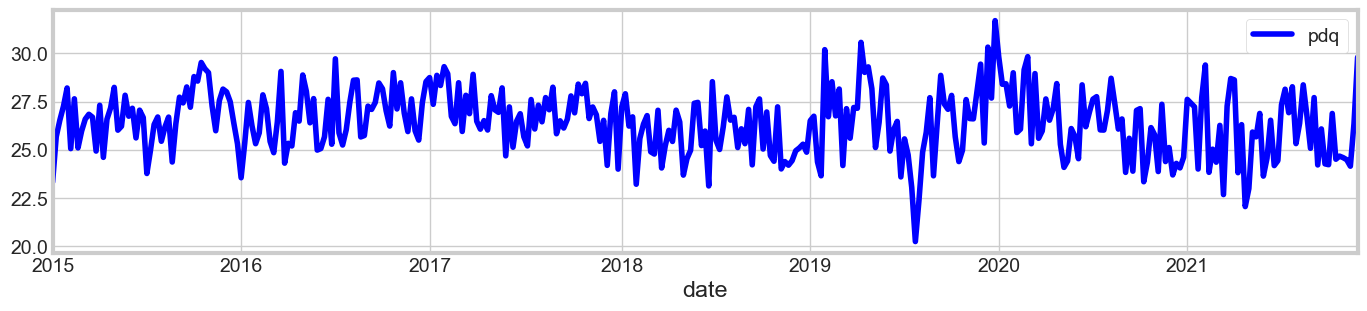

In [47]:
# graficar datos
y_s1.plot(figsize=(15, 3),color = 'blue')
plt.show()

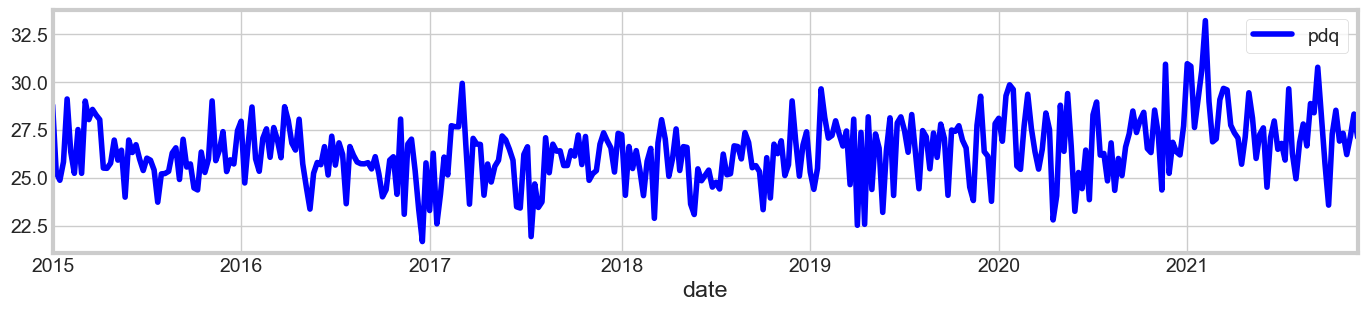

In [48]:
y_s2.head()
# graficar datos
y_s2.plot(figsize=(15, 3),color = 'blue')
plt.show()

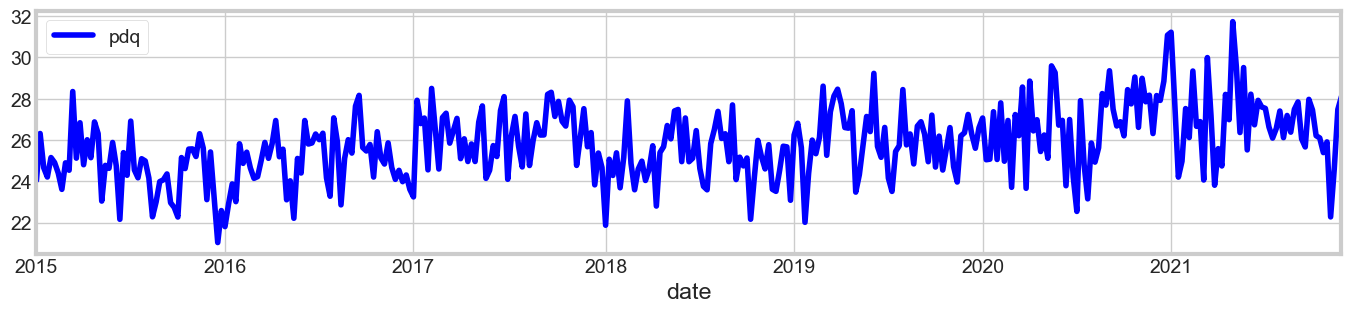

In [49]:
y_s3.head()
# graficar datos
y_s3.plot(figsize=(15, 3),color = 'blue')
plt.show()

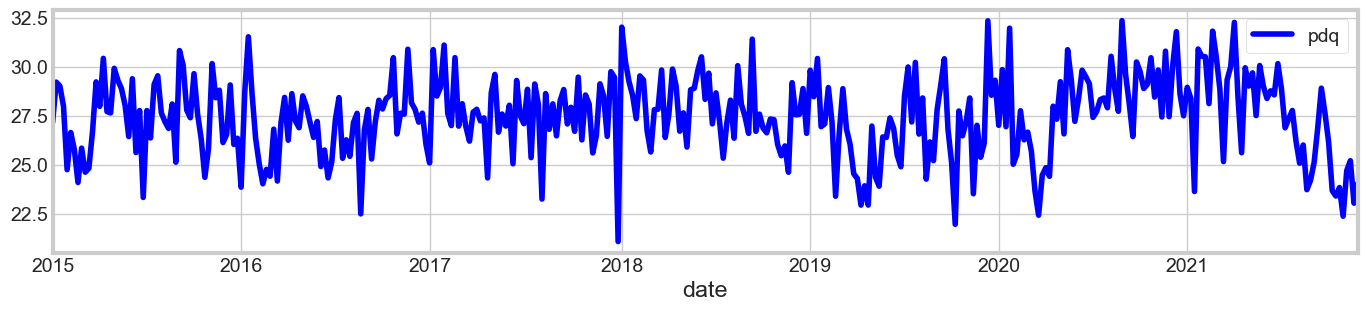

In [50]:
y_s4.head()
# graficar datos
y_s4.plot(figsize=(15, 3),color = 'blue')
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [51]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

Para nuestro análisis utilizaremos $y_{s3}$.

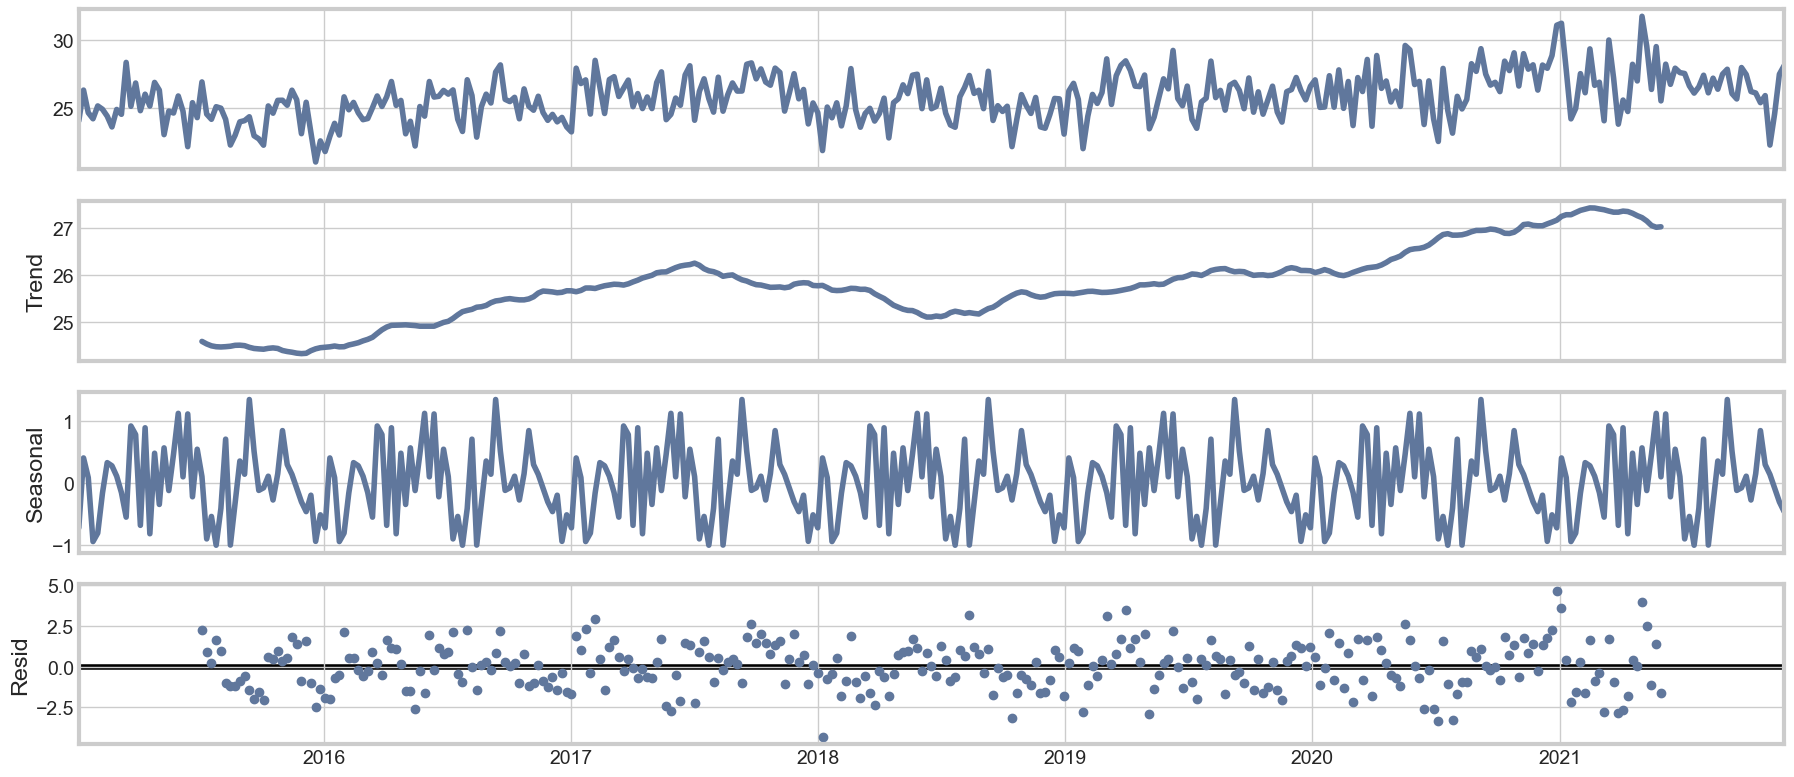

In [52]:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s3, model='aditive')
fig = decomposition.plot()
plt.show()

Luego de hacer la descomposición vemos que hay un claro patrón para Seasonal y la tendencia parece aunque tiene una valle parece ir en subida.

In [53]:
import warnings

warnings.filterwarnings("ignore")

# lista para guardar resultados
results = []

for param in params:
    try:
        model = SarimaModels(param)
        df_metrics = model.metrics(y_s3, target_date)
        results.append(df_metrics)
    except Exception as e:
        print(f"Error con {param}: {e}")

# concatenar todos los resultados
df_results = pd.concat(results, ignore_index=True)
df_results.head()

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,26.8918,726.4179,26.9521,1.0000,0.7854,1.0000,0.9640,2.0000,"SARIMA_(0,0,0)X(0,0,0,12)"
1,23.2099,586.6421,24.2207,0.8634,0.6930,0.8631,0.8323,1.6564,"SARIMA_(0,0,0)X(0,0,1,12)"
2,1.9803,5.9242,2.4340,0.0756,0.0751,0.0736,0.0728,0.0721,"SARIMA_(0,0,0)X(0,1,0,12)"
3,1.3695,3.4389,1.8544,0.0502,0.0500,0.0509,0.0484,0.0509,"SARIMA_(0,0,0)X(0,1,1,12)"
4,2.0698,6.3449,2.5189,0.0790,0.0785,0.0770,0.0761,0.0752,"SARIMA_(0,0,0)X(1,0,0,12)"


In [73]:
best_model = df_results.sort_values(by='rmse').iloc[0]

best_params = eval(best_model['model'].split('_')[1].replace('X',','))  # o simplemente guarda los params antes
sarima_best = SarimaModels(best_params)
model_fit = sarima_best.fit_model(y_s3, target_date)

best_model

mae                         1.3657
mse                         3.1739
rmse                        1.7815
mape                        0.0511
maape                       0.0509
wmape                       0.0508
mmape                       0.0492
smape                       0.0508
model    SARIMA_(1,0,0)X(1,0,1,12)
Name: 37, dtype: object

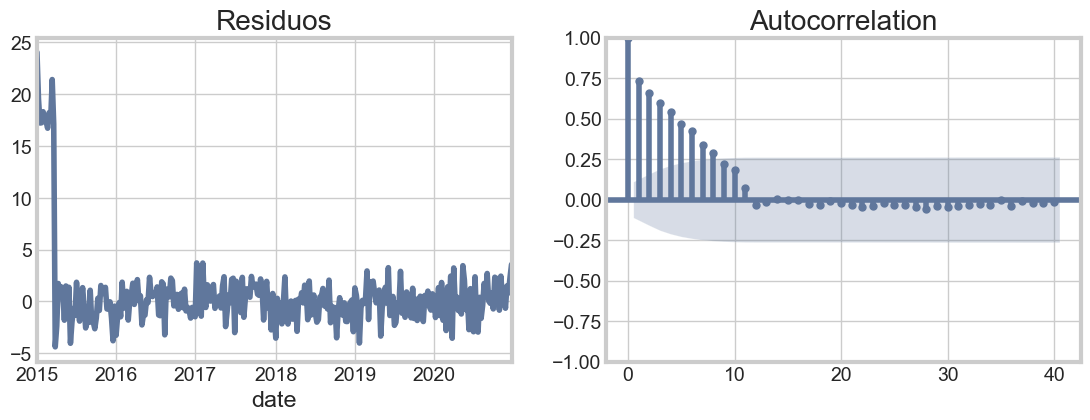

In [55]:
import statsmodels.api as sm

residuals = model_fit.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
residuals.plot(title="Residuos", ax=axes[0])
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axes[1])
plt.show()

In [56]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box)

       lb_stat      lb_pvalue
10  730.277346  1.980067e-150


El test ljung_box, recomendado por ChatGPT, no es concluyente para afirmar que el residuo es en efecto un ruido blanco, el $p-$valor es muy bajo. Además, la correlación parece tener una cierta estructura, lo que nos dice que muy posiblemente el residuo no es solamente ruido blanco.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


01:03:35 - cmdstanpy - INFO - Chain [1] start processing
01:03:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 1.59, RMSE: 2.12, MAPE: 6.08%


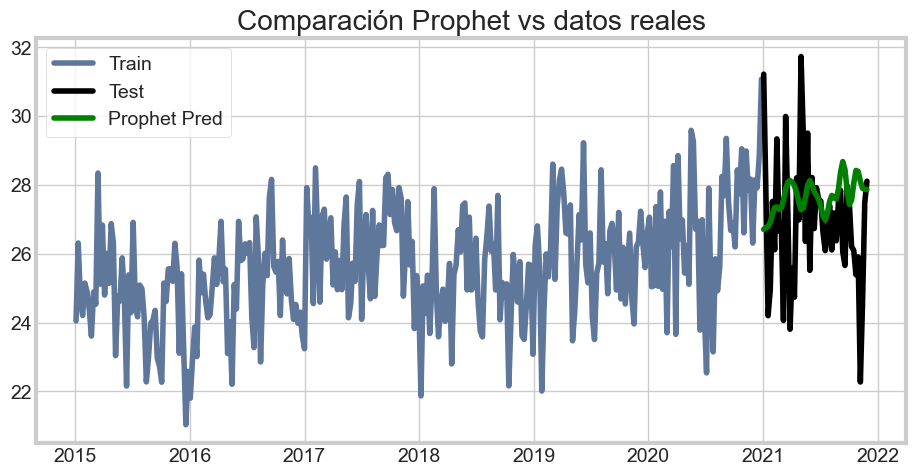

In [72]:
from prophet import Prophet

# suponiendo que tu DataFrame se llama y
df_prophet = y_s3.reset_index().rename(columns={'date': 'ds', 'pdq': 'y'})

# dividir train y test según tu fecha objetivo
mask_train = df_prophet['ds'] < target_date
train = df_prophet[mask_train]
test = df_prophet[~mask_train]

model_prophet = Prophet(seasonality_mode='additive', yearly_seasonality=True)
model_prophet.fit(train)

# usar las fechas de test para predecir
future = test[['ds']]
forecast = model_prophet.predict(future)

# combinar resultados reales y predichos
df_results_prophet = pd.DataFrame({
    'ds': test['ds'].reset_index(drop=True),
    'y': test['y'].reset_index(drop=True),
    'yhat': forecast['yhat'].reset_index(drop=True)
})

from sklearn.metrics import mean_absolute_error, mean_squared_error
df_results_prophet = df_results_prophet.dropna(subset=['y', 'yhat'])
mae_p = mean_absolute_error(df_results_prophet['y'], df_results_prophet['yhat'])
rmse_p = np.sqrt(mean_squared_error(df_results_prophet['y'], df_results_prophet['yhat']))
mape_p = np.mean(np.abs((df_results_prophet['y'] - df_results_prophet['yhat']) / df_results_prophet['y'])) * 100

print(f"Prophet - MAE: {mae_p:.2f}, RMSE: {rmse_p:.2f}, MAPE: {mape_p:.2f}%")

plt.figure(figsize=(10,5))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test', color='black')
plt.plot(df_results_prophet['ds'], df_results_prophet['yhat'], label='Prophet Pred', color='green')
plt.legend()
plt.title('Comparación Prophet vs datos reales')
plt.show()

El MAE de Prophet es levemente mayor, sin embargo notamos que en el RMSE Prophet tuvo mejores resultados.

In [74]:
df_results_prophet['residual'] = df_results_prophet['y'] - df_results_prophet['yhat']
residuals = df_results_prophet['residual']

In [75]:
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_result)

     lb_stat  lb_pvalue
10  6.867722   0.737871


Una diferencia que vemos es que en este caso sí es concluyente el método ljung_box para indicar que el residuo es en efecto ruido blanco.